In [87]:
from mueller_matrices import M_Retarder, M_Diattenuator, M_rotate, M_LinearPolarizer, stokes2ellipse
from plotting import plotEllipse, plotEllipseStokes
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

In [165]:
def M_inst_e(e):
    M = sp.Matrix([[1, 0, 0, -1],
                  [1, np.cos(2*np.arctan(e)), 0, -np.sin(2*np.arctan(e))],
                  [1, -0.5*np.cos(2*np.arctan(e)), np.sqrt(3)/2*np.cos(2*np.arctan(e)), -np.sin(2*np.arctan(e))],
                  [1, -0.5*np.cos(2*np.arctan(e)), -np.sqrt(3)/2*np.cos(2*np.arctan(e)), -np.sin(2*np.arctan(e))]])
                   
    return M

def M_inst_swing(chi):
    M = sp.Matrix([[1, 0, 0, -1],
                  [1, np.sin(2*np.pi*chi), 0, -np.cos(2*np.pi*chi)],
                  [1, -0.5*np.sin(2*np.pi*chi), np.sqrt(3)*np.cos(np.pi*chi)*np.sin(np.pi*chi), -np.cos(2*np.pi*chi)],
                  [1, -0.5*np.sin(2*np.pi*chi), -np.sqrt(3)/2*np.sin(2*np.pi*chi), -np.cos(2*np.pi*chi)]])
                   
    return M

def M_inst_swing_std(chi):
    M = sp.Matrix([[1, 0, 0, -1],
                  [1, np.sin(2*np.pi*chi), 0, -np.cos(2*np.pi*chi)],
                  [1, 0, np.sin(2*np.pi*chi), -np.cos(2*np.pi*chi)],
                  [1, -np.sin(2*np.pi*chi), 0, -np.cos(2*np.pi*chi)],
                  [1, 0, -np.sin(2*np.pi*chi), -np.cos(2*np.pi*chi)]])
                   
    return M

def S_spec(t, p, slow, ret):
    S = sp.Matrix([[t],
                  [t*p*np.sin(2*slow)*np.sin(ret)],
                  [-t*p*np.cos(2*slow)*np.sin(ret)],
                  [t*p*np.cos(ret)]])
    return S

def genStarTarget(N, M, blur_px = 2, radius=100):
    '''
    generate Siemens star for simulation target
    Input:
        (N, M)  : (y, x) dimension of the simulated image
        blur_px : degree of the blurring imposed on the generated image
    Output:
        star    : Siemens star with the size of (N, M)
        theta   : polar angle np array with the size of (N, M)
    '''
    # Construct Siemens star
    x = np.r_[:N]-N//2
    y = np.r_[:M]-M//2
    xcent = M//2
    ycent = N//2
    xx, yy = np.meshgrid(x,y)
    rho = np.sqrt(xx**2 + yy**2)
    theta = np.arctan2(yy, xx)
    star = (1 + np.cos(16*theta))
    star[star<1] = 0
    for i in range(N):
        for j in range(M):
            r = np.sqrt((i - xcent)**2 + (j - ycent)**2)
            if r > radius:
                star[i,j] = 0
    # Filter to prevent aliasing
    Gaussian = np.exp(-rho**2/(2*blur_px**2))
    star = np.maximum(0, np.real(np.fft.ifft2(np.fft.fft2(star) * np.fft.fft2(np.fft.ifftshift(Gaussian)))))
    star /= np.max(star)
    
    return star, theta, xx

In [161]:
N = 500
M = 500
star, theta, xx = genStarTarget(N,M, blur_px=1, radius=200)

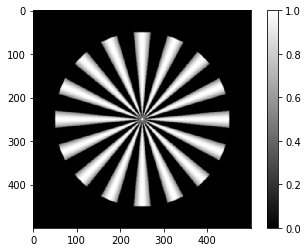

In [162]:
plt.imshow(star, 'gray')
# plt.axis('off')
plt.colorbar()
plt.show()

### Simulate the Extinction, 0, 60, and 120 deg polarization states

In [163]:
%%time

# inten = np.zeros([4,1,2048,2048])
I_lcp = np.zeros([N,M])
I_0 = np.zeros([N,M])
I_60 = np.zeros([N,M])
I_120 = np.zeros([N,M])
swing = 0.03

t = np.ones(xx.shape)
p = np.ones(xx.shape)

for i in range(N):
    for j in range(M):
        s = M_inst_swing(swing) * S_spec(t[i,j], p[i,j], theta[i,j]+np.pi/2, star[i,j])
        I_lcp[i,j] = s[0]
        I_0[i,j] = s[1]
        I_60[i,j] = s[2]
        I_120[i,j] = s[3]
#         inten[:,i,j] = M_inst_swing(swing) * S_spec(t[i,j], p[i,j], theta[i,j], star[i,j])

CPU times: user 2min 54s, sys: 573 ms, total: 2min 55s
Wall time: 2min 56s


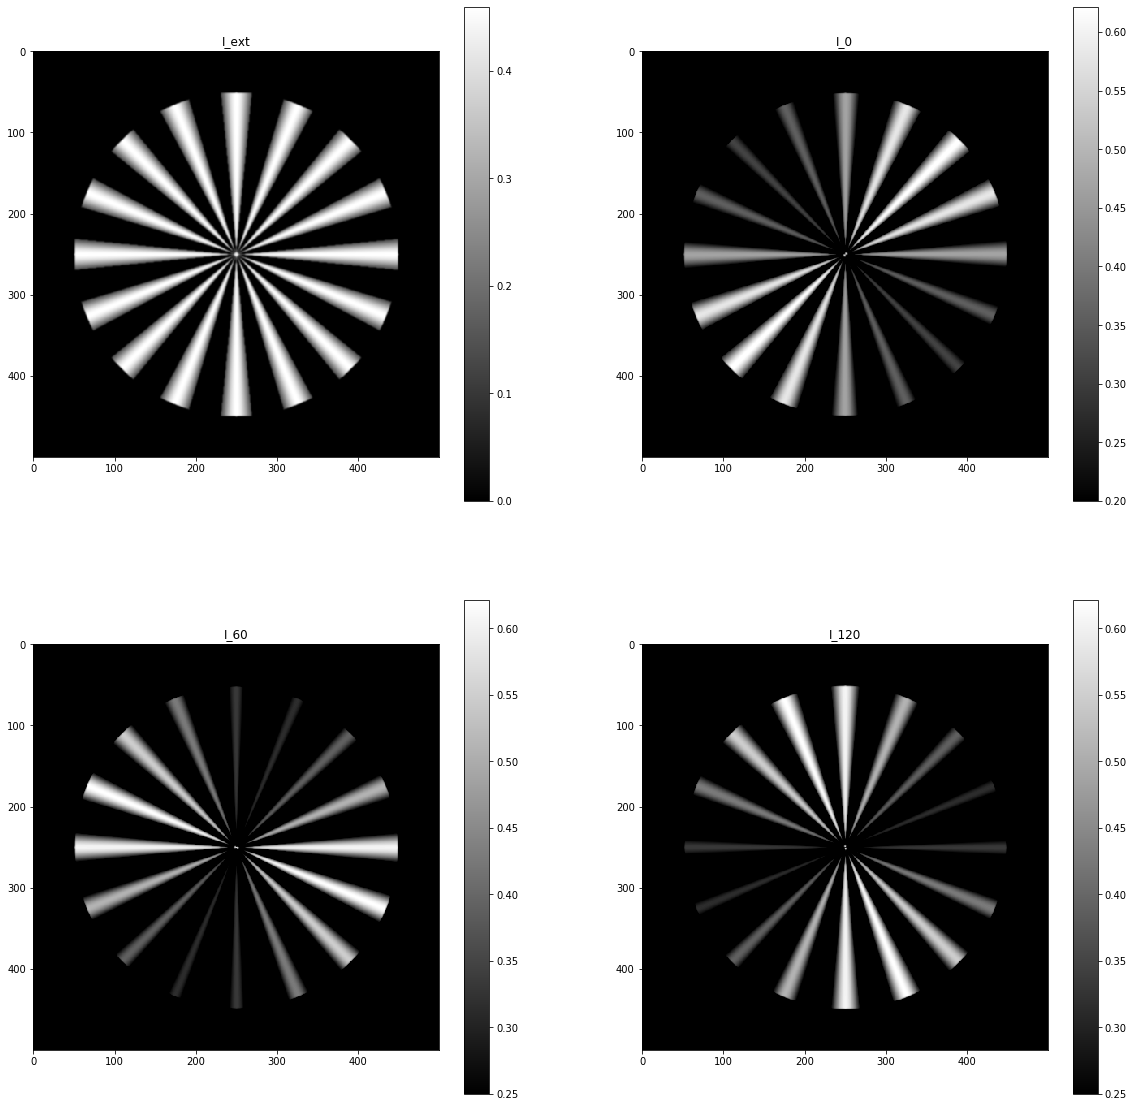

In [164]:
fig1 = plt.figure(figsize=(20,20)) # create a figure with the default size 

ax1 = fig1.add_subplot(2,2,1) 
im=plt.imshow(I_lcp,cmap='gray', origin='upper');
plt.title('I_ext')
ax1.figure.colorbar(im);

ax2=fig1.add_subplot(2,2,2)
im=plt.imshow(I_0,cmap='gray', origin='upper');
plt.title('I_0')
plt.clim([.2,np.max(I_60)])
ax2.figure.colorbar(im);

ax3=fig1.add_subplot(2,2,3)
im=plt.imshow(I_60,cmap='gray', origin='upper');
plt.title('I_60')
plt.clim([.25,np.max(I_60)])
ax3.figure.colorbar(im);

ax4=fig1.add_subplot(2,2,4)
im=plt.imshow(I_120,cmap='gray', origin='upper');
plt.title('I_120')
plt.clim([.25,np.max(I_60)])
ax4.figure.colorbar(im);

### Simulate the Extinction, 0, 45, 90, and 135 deg polarization states

In [180]:
%%time

# inten = np.zeros([4,1,2048,2048])
I_lcp_std = np.zeros([N,M])
I_0_std = np.zeros([N,M])
I_45 = np.zeros([N,M])
I_90 = np.zeros([N,M])
I_135 = np.zeros([N,M])
swing = 0.03

t = np.ones(xx.shape)
p = np.ones(xx.shape)

for i in range(N):
    for j in range(M):
        s = M_inst_swing_std(swing) * S_spec(t[i,j], p[i,j], theta[i,j]+np.pi/2, star[i,j])
        I_lcp_std[i,j] = s[0]
        I_0_std[i,j] = s[1]
        I_45[i,j] = s[2]
        I_90[i,j] = s[3]
        I_135[i,j] = s[4]
#         inten[:,i,j] = M_inst_swing(swing) * S_spec(t[i,j], p[i,j], theta[i,j], star[i,j])

CPU times: user 3min 4s, sys: 643 ms, total: 3min 5s
Wall time: 3min 6s


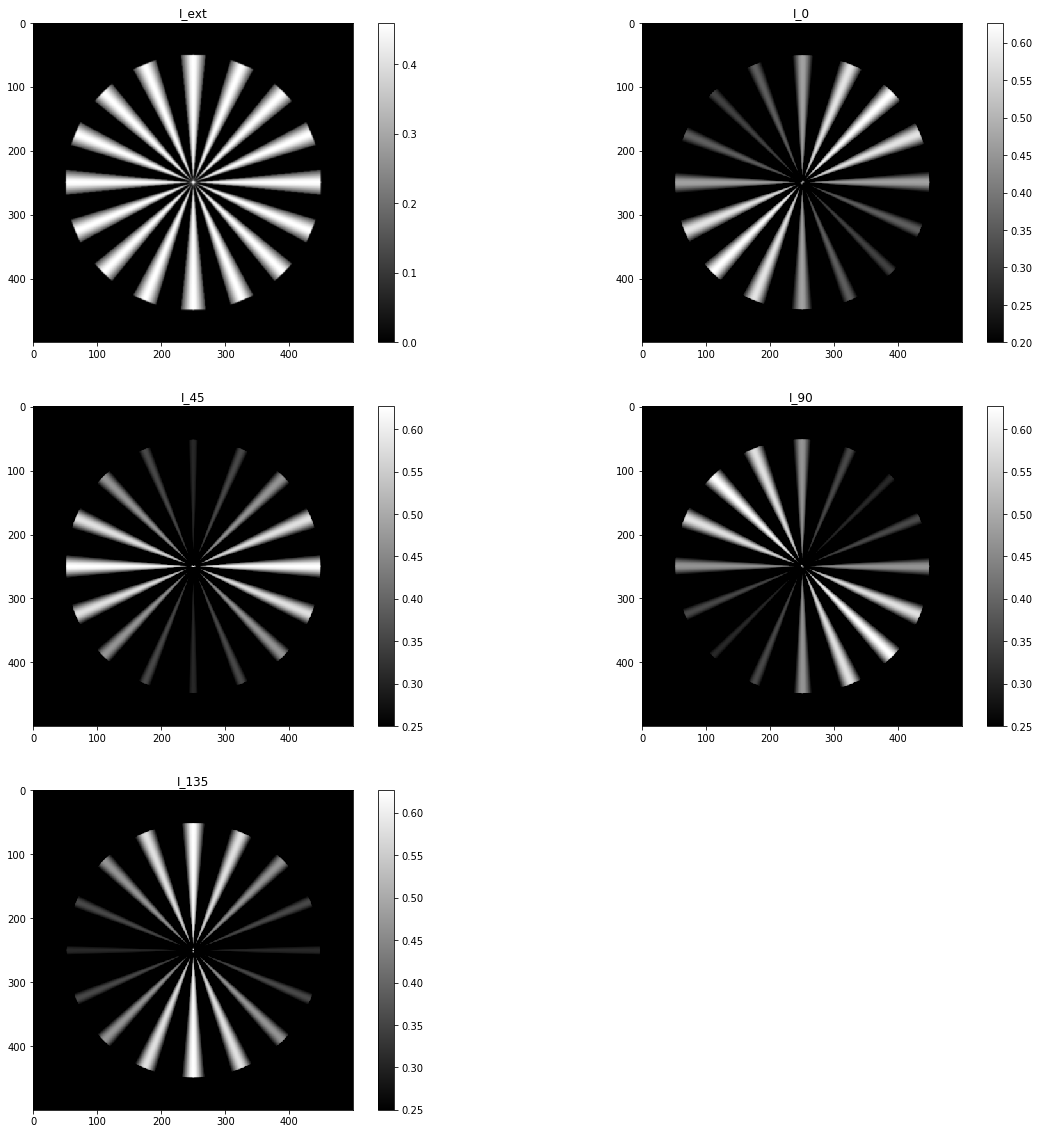

In [181]:
fig1 = plt.figure(figsize=(20,20)) # create a figure with the default size 

ax1 = fig1.add_subplot(3,2,1) 
im=plt.imshow(I_lcp_std,cmap='gray', origin='upper');
plt.title('I_ext')
ax1.figure.colorbar(im);

ax2=fig1.add_subplot(3,2,2)
im=plt.imshow(I_0_std,cmap='gray', origin='upper');
plt.title('I_0')
plt.clim([.2,np.max(I_0)])
ax2.figure.colorbar(im);

ax3=fig1.add_subplot(3,2,3)
im=plt.imshow(I_45,cmap='gray', origin='upper');
plt.title('I_45')
plt.clim([.25,np.max(I_45)])
ax3.figure.colorbar(im);

ax4=fig1.add_subplot(3,2,4)
im=plt.imshow(I_90,cmap='gray', origin='upper');
plt.title('I_90')
plt.clim([.25,np.max(I_90)])
ax4.figure.colorbar(im);

ax5=fig1.add_subplot(3,2,5)
im=plt.imshow(I_135,cmap='gray', origin='upper');
plt.title('I_135')
plt.clim([.25,np.max(I_135)])
ax4.figure.colorbar(im);